In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import os


In [3]:
data = torch.load('TrainingDataset/Kcat_Enzymatic_reaction.pt',weights_only=False)
data.head()

,ECNumber,Organism,Smiles,Substrate,Sequence,Raw Kd,Unit,Log Kd
0,4.2.3.4,Actinidia chinensis,C(C(C(C(COP(=O)(O)O)O)O)O)C(=O)C(=O)O,3-deoxy-D-arabino-heptulosonic acid 7-phosphate,MAAFSLSAKQILSPSTHRPSLSKTTTADSSLRFRNPHSLSLRCSSL...,20.1000,s^(-1),1.303196
1,4.2.3.4,Aspergillus nidulans,C(C(C(C(COP(=O)([O-])[O-])O)O)O)C(=O)C(=O)[O-],3-deoxy-D-arabino-heptulosonate 7-phosphate,MSNPTKISILGRESIIADFGLWRNYVAKDLISDCSSTTYVLVTDTN...,6.8000,s^(-1),0.832509
2,4.2.3.4,Neurospora crassa,C(C(C(C(COP(=O)(O)O)O)O)O)C(=O)C(=O)O,3-deoxy-D-arabino-heptulosonic acid 7-phosphate,MAEPISNPTRINILGKDNIIIDHGIWLNFVAQDLLQNIKSSTYILI...,19.0000,s^(-1),1.278754
3,2.1.1.255,Streptomyces coelicolor,C[S+](CCC(C(=O)[O-])N)CC1C(C(C(O1)N2C=NC3=C(N=...,S-Adenosyl-L-methionine,MTTETTTATATAKIPAPATPYQEDIARYWNNEARPVNLRLGDVDGL...,0.0075,s^(-1),-2.124939
4,2.1.1.255,Streptomyces coelicolor,CC(=CCCC(=C(C)COP(=O)(O)OP(=O)(O)O)C)C,(E)-2-Methylgeranyl diphosphate,MTTETTTATATAKIPAPATPYQEDIARYWNNEARPVNLRLGDVDGL...,0.0390,s^(-1),-1.408935


In [4]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load ChemRoBERTa tokenizer and model
chem_tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
chem_model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# Load ESM2 tokenizer and model
esm_tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
esm_model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
def extract_chem_features(smiles):
    """Extract ChemRoBERTa features from SMILES."""
    try:
        tokens = chem_tokenizer(smiles, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            embeddings = chem_model(**tokens).last_hidden_state.mean(dim=1).squeeze().numpy()
        return embeddings
    except:
        return np.zeros(768)  # Return zero vector if extraction fails

def extract_esm_features(sequence):
    """Extract ESM2 features from protein sequence."""
    try:
        tokens = esm_tokenizer(sequence, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            embeddings = esm_model(**tokens).last_hidden_state.mean(dim=1).squeeze().numpy()
        return embeddings
    except:
        return np.zeros(768)  # Return zero vector if extraction fails

In [6]:
# Extract unique mols and proteins
unique_mols = data[['Smiles']].drop_duplicates()
unique_proteins = data[['Sequence']].drop_duplicates()

In [7]:
len(unique_mols), len(unique_proteins)

(2706, 7857)

In [8]:
# Extract features for unique mols
tqdm.pandas()  # Enable progress bar for pandas
unique_mols['metabolite_features'] = unique_mols['Smiles'].progress_apply(extract_chem_features)

100%|██████████| 2706/2706 [00:48<00:00, 55.92it/s]


In [ ]:
# Extract features for unique proteins
unique_proteins['protein_features'] = unique_proteins['Sequence'].progress_apply(extract_esm_features)

 80%|███████▉  | 6273/7857 [05:47<01:37, 16.31it/s]  

In [ ]:
# Merge features back into the combined dataframe
data = data.merge(unique_mols, on='Smiles', how='left')
data = data.merge(unique_proteins, on='Sequence', how='left')

In [ ]:
print(data.columns)

Index(['ECNumber', 'Organism', 'Smiles', 'Substrate', 'Sequence', 'Raw Kd',
       'Unit', 'Log Kd', 'metabolite_features', 'protein_features'],
      dtype='object')


In [ ]:
# adding 1e-9 to prevent error when doing logarithm
# ??????
data['label'] = -np.log10(data['Raw Kd'] + 1e-9)

In [ ]:
# Define dataset
class MPI_Dataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        return {
            'metabolite_features': torch.tensor(np.asarray(row['metabolite_features'], dtype=np.float32)),
            'protein_features': torch.tensor(np.asarray(row['protein_features'], dtype=np.float32)),
            'label': torch.tensor(float(row['label']), dtype=torch.float32),
        }

In [ ]:
# Load data
# Assuming `combined_df` is a pandas DataFrame containing all necessary columns
train_df, temp_df = train_test_split(data, test_size=0.3, shuffle=True, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True, random_state=42)

train_dataset = MPI_Dataset(train_df)
val_dataset = MPI_Dataset(val_df)
test_dataset = MPI_Dataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
# cold splitting



In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F

# Define MLP Model for Regression
class MLPRegressor(nn.Module):
    def __init__(self, mol_input_dim, protein_input_dim, hidden_dim=128):
        super(MLPRegressor, self).__init__()

        self.mol_encoder = nn.Linear(mol_input_dim, hidden_dim)
        self.protein_encoder = nn.Linear(protein_input_dim, hidden_dim)
        
        # norm layer + Dropout
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(0.3)

        # hidden layer + output layer
        self.hidden = nn.Linear(hidden_dim * 2, hidden_dim)
        self.regressor = nn.Linear(hidden_dim, 1)

        self.activation = nn.ReLU()

    def forward(self, mol_input, protein_input):
        # Reshape to (B, 1, L) for Conv1d
        mol_embedding = self.activation(self.mol_encoder(mol_input))
        protein_embedding = self.activation(self.protein_encoder(protein_input))

        # Concatenate + Normalize + Dropout
        combined = torch.cat((mol_embedding, protein_embedding), dim=-1)
        combined = self.layer_norm(combined)
        combined = self.dropout(combined)

        # Hidden → Regress
        hidden_out = self.activation(self.hidden(combined))
        output = self.regressor(hidden_out)

        return output.squeeze(1)


In [ ]:
# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import r2_score, median_absolute_error, explained_variance_score
from scipy.stats import pearsonr


train_history = pd.DataFrame(columns=[  'epoch',
    'Train Loss', 'Train MSE', 'Train MAE', 'Train RMSE', 'Train R2', 'Train Pearson', 'Train Median_AE', 'Train Explained_VAR'
    'Val Loss', 'Val MSE', 'Val MAE', 'Val RMSE', 'Val R2', 'Val Pearson', 'Val Median_AE', 'Val Explained_VAR'])
# Verify feature dimensions
for batch in train_loader:
    mol_input_dim = batch['metabolite_features'].shape[1]  # Dynamically determine mol input dimension
    protein_input_dim = batch['protein_features'].shape[1]  # Dynamically determine protein input dimension
    break

# Initialize model, optimizer, and loss function
num_timesteps = 10
model = MLPRegressor(mol_input_dim=mol_input_dim, protein_input_dim=protein_input_dim,hidden_dim=512)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

# Training and Validation Loop
for epoch in range(2000):
    model.train()
    total_loss = 0.0
    val_total_loss = 0.0
    train_predictions, train_labels = [], []

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(mol_features, protein_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Store predictions and labels for metrics
        train_predictions.extend(outputs.detach().cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Calculate training metrics
    train_mse = ((torch.tensor(train_predictions) - torch.tensor(train_labels))**2).mean().item()
    train_mae = torch.abs(torch.tensor(train_predictions) - torch.tensor(train_labels)).mean().item()



    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Train Loss: {total_loss / len(train_loader):.4f}, Train MSE: {train_mse:.4f}, Train MAE: {train_mae:.4f}")

    # Validation
    model.eval()
    val_predictions, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            mol_features = batch['metabolite_features'].to(device)
            protein_features = batch['protein_features'].to(device)
            labels = batch['label'].to(device)

            outputs = model(mol_features, protein_features)
            val_predictions.extend(outputs.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            val_loss = criterion(outputs, labels)
            val_total_loss += val_loss.item()

    val_mse = ((torch.tensor(val_predictions) - torch.tensor(val_labels))**2).mean().item()
    val_mae = torch.abs(torch.tensor(val_predictions) - torch.tensor(val_labels)).mean().item()


    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Validation Loss: {val_total_loss / len(val_loader):.4f}, Validation MSE: {val_mse:.4f}, Validation MAE: {val_mae:.4f}")

    # Save metrics to DataFrame
    new_row = {'epoch': epoch + 1, 'Train Loss': total_loss / len(train_loader), 'Train MSE': train_mse, 'Train MAE': train_mae, 'Train RMSE': train_rmse, 'Train R2': train_r2, 'Train Pearson': train_pearson_corr, 'Train Median_AE': train_median_ae, 'Train Explained_VAR': train_explained_var, 
               'Val Loss': val_total_loss / len(val_loader), 'Val MSE': val_mse, 'Val MAE': val_mae, 'Val RMSE': val_rmse, 'Val R2': val_r2, 'Val Pearson': val_pearson_corr, 'Val Median_AE': val_median_ae, 'Val Explained_VAR': val_explained_var}
    train_history = pd.concat([train_history, pd.DataFrame([new_row])], ignore_index=True)



Training Epoch 1: 100%|██████████| 373/373 [00:02<00:00, 167.21it/s]
/var/folders/yz/c1z6m9_d5d3f80sywjc3rqsc0000gn/T/ipykernel_90273/3478497585.py:92: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_history = pd.concat([train_history, pd.DataFrame([new_row])], ignore_index=True)


Epoch 0 - Train Loss: 2.0025, Train MSE: 2.0059, Train MAE: 1.0997
Epoch 0 - Validation Loss: 1.8754, Validation MSE: 1.8759, Validation MAE: 1.0476


Training Epoch 11: 100%|██████████| 373/373 [00:01<00:00, 188.29it/s]


Epoch 10 - Train Loss: 1.3521, Train MSE: 1.3525, Train MAE: 0.8867
Epoch 10 - Validation Loss: 1.5349, Validation MSE: 1.5370, Validation MAE: 0.9390


Training Epoch 21: 100%|██████████| 373/373 [00:02<00:00, 185.23it/s]


Epoch 20 - Train Loss: 1.0922, Train MSE: 1.0938, Train MAE: 0.7920
Epoch 20 - Validation Loss: 1.3036, Validation MSE: 1.3065, Validation MAE: 0.8413


Training Epoch 31: 100%|██████████| 373/373 [00:01<00:00, 189.34it/s]


Epoch 30 - Train Loss: 0.9449, Train MSE: 0.9456, Train MAE: 0.7291
Epoch 30 - Validation Loss: 1.2608, Validation MSE: 1.2634, Validation MAE: 0.8178


Training Epoch 41: 100%|██████████| 373/373 [00:01<00:00, 189.48it/s]


Epoch 40 - Train Loss: 0.8723, Train MSE: 0.8731, Train MAE: 0.6965
Epoch 40 - Validation Loss: 1.2252, Validation MSE: 1.2279, Validation MAE: 0.8037


Training Epoch 51: 100%|██████████| 373/373 [00:01<00:00, 191.19it/s]


Epoch 50 - Train Loss: 0.8031, Train MSE: 0.8049, Train MAE: 0.6663
Epoch 50 - Validation Loss: 1.2139, Validation MSE: 1.2168, Validation MAE: 0.7885


Training Epoch 61: 100%|██████████| 373/373 [00:01<00:00, 192.10it/s]


Epoch 60 - Train Loss: 0.7715, Train MSE: 0.7724, Train MAE: 0.6497
Epoch 60 - Validation Loss: 1.1936, Validation MSE: 1.1965, Validation MAE: 0.7702


Training Epoch 71: 100%|██████████| 373/373 [00:01<00:00, 193.22it/s]


Epoch 70 - Train Loss: 0.7201, Train MSE: 0.7212, Train MAE: 0.6229
Epoch 70 - Validation Loss: 1.2176, Validation MSE: 1.2203, Validation MAE: 0.7819


Training Epoch 81: 100%|██████████| 373/373 [00:01<00:00, 190.39it/s]


Epoch 80 - Train Loss: 0.6915, Train MSE: 0.6932, Train MAE: 0.6067
Epoch 80 - Validation Loss: 1.1939, Validation MSE: 1.1964, Validation MAE: 0.7758


Training Epoch 91: 100%|██████████| 373/373 [00:01<00:00, 191.91it/s]


Epoch 90 - Train Loss: 0.6783, Train MSE: 0.6766, Train MAE: 0.5971
Epoch 90 - Validation Loss: 1.1983, Validation MSE: 1.2005, Validation MAE: 0.7688


Training Epoch 101: 100%|██████████| 373/373 [00:01<00:00, 193.05it/s]


Epoch 100 - Train Loss: 0.6555, Train MSE: 0.6548, Train MAE: 0.5848
Epoch 100 - Validation Loss: 1.1810, Validation MSE: 1.1832, Validation MAE: 0.7633


Training Epoch 111: 100%|██████████| 373/373 [00:01<00:00, 193.54it/s]


Epoch 110 - Train Loss: 0.6322, Train MSE: 0.6328, Train MAE: 0.5702
Epoch 110 - Validation Loss: 1.2179, Validation MSE: 1.2204, Validation MAE: 0.7732


Training Epoch 121: 100%|██████████| 373/373 [00:01<00:00, 191.49it/s]


Epoch 120 - Train Loss: 0.6244, Train MSE: 0.6226, Train MAE: 0.5673
Epoch 120 - Validation Loss: 1.2022, Validation MSE: 1.2045, Validation MAE: 0.7617


Training Epoch 131: 100%|██████████| 373/373 [00:01<00:00, 194.80it/s]


Epoch 130 - Train Loss: 0.6150, Train MSE: 0.6165, Train MAE: 0.5601
Epoch 130 - Validation Loss: 1.2021, Validation MSE: 1.2046, Validation MAE: 0.7664


Training Epoch 141: 100%|██████████| 373/373 [00:01<00:00, 192.70it/s]


Epoch 140 - Train Loss: 0.5922, Train MSE: 0.5931, Train MAE: 0.5487
Epoch 140 - Validation Loss: 1.1822, Validation MSE: 1.1847, Validation MAE: 0.7526


Training Epoch 151: 100%|██████████| 373/373 [00:01<00:00, 193.15it/s]


Epoch 150 - Train Loss: 0.5985, Train MSE: 0.5998, Train MAE: 0.5496
Epoch 150 - Validation Loss: 1.2082, Validation MSE: 1.2107, Validation MAE: 0.7628


Training Epoch 161: 100%|██████████| 373/373 [00:01<00:00, 194.45it/s]


Epoch 160 - Train Loss: 0.5823, Train MSE: 0.5832, Train MAE: 0.5418
Epoch 160 - Validation Loss: 1.1954, Validation MSE: 1.1980, Validation MAE: 0.7584


Training Epoch 171: 100%|██████████| 373/373 [00:01<00:00, 190.55it/s]


Epoch 170 - Train Loss: 0.5768, Train MSE: 0.5774, Train MAE: 0.5382
Epoch 170 - Validation Loss: 1.2229, Validation MSE: 1.2250, Validation MAE: 0.7712


Training Epoch 181: 100%|██████████| 373/373 [00:02<00:00, 185.80it/s]


Epoch 180 - Train Loss: 0.5646, Train MSE: 0.5651, Train MAE: 0.5274
Epoch 180 - Validation Loss: 1.1936, Validation MSE: 1.1953, Validation MAE: 0.7680


Training Epoch 191: 100%|██████████| 373/373 [00:01<00:00, 195.89it/s]


Epoch 190 - Train Loss: 0.5600, Train MSE: 0.5581, Train MAE: 0.5247
Epoch 190 - Validation Loss: 1.2133, Validation MSE: 1.2159, Validation MAE: 0.7585


Training Epoch 201: 100%|██████████| 373/373 [00:01<00:00, 196.78it/s]


Epoch 200 - Train Loss: 0.5532, Train MSE: 0.5541, Train MAE: 0.5217
Epoch 200 - Validation Loss: 1.1812, Validation MSE: 1.1839, Validation MAE: 0.7556


Training Epoch 211: 100%|██████████| 373/373 [00:01<00:00, 196.82it/s]


Epoch 210 - Train Loss: 0.5371, Train MSE: 0.5382, Train MAE: 0.5139
Epoch 210 - Validation Loss: 1.2103, Validation MSE: 1.2127, Validation MAE: 0.7580


Training Epoch 221: 100%|██████████| 373/373 [00:02<00:00, 168.82it/s]


Epoch 220 - Train Loss: 0.5384, Train MSE: 0.5395, Train MAE: 0.5149
Epoch 220 - Validation Loss: 1.2014, Validation MSE: 1.2036, Validation MAE: 0.7575


Training Epoch 231: 100%|██████████| 373/373 [00:02<00:00, 165.17it/s]


Epoch 230 - Train Loss: 0.5453, Train MSE: 0.5455, Train MAE: 0.5137
Epoch 230 - Validation Loss: 1.2109, Validation MSE: 1.2131, Validation MAE: 0.7591


Training Epoch 241: 100%|██████████| 373/373 [00:02<00:00, 157.64it/s]


Epoch 240 - Train Loss: 0.5268, Train MSE: 0.5269, Train MAE: 0.5048
Epoch 240 - Validation Loss: 1.1956, Validation MSE: 1.1980, Validation MAE: 0.7549


Training Epoch 251: 100%|██████████| 373/373 [00:02<00:00, 164.35it/s]


Epoch 250 - Train Loss: 0.5190, Train MSE: 0.5202, Train MAE: 0.5006
Epoch 250 - Validation Loss: 1.1932, Validation MSE: 1.1957, Validation MAE: 0.7555


Training Epoch 261: 100%|██████████| 373/373 [00:02<00:00, 165.65it/s]


Epoch 260 - Train Loss: 0.5188, Train MSE: 0.5192, Train MAE: 0.5005
Epoch 260 - Validation Loss: 1.1905, Validation MSE: 1.1926, Validation MAE: 0.7456


Training Epoch 271: 100%|██████████| 373/373 [00:02<00:00, 165.37it/s]


Epoch 270 - Train Loss: 0.5154, Train MSE: 0.5147, Train MAE: 0.4958
Epoch 270 - Validation Loss: 1.1917, Validation MSE: 1.1941, Validation MAE: 0.7520


Training Epoch 281: 100%|██████████| 373/373 [00:02<00:00, 166.48it/s]


Epoch 280 - Train Loss: 0.5122, Train MSE: 0.5131, Train MAE: 0.4973
Epoch 280 - Validation Loss: 1.1942, Validation MSE: 1.1967, Validation MAE: 0.7543


Training Epoch 291: 100%|██████████| 373/373 [00:02<00:00, 166.91it/s]


Epoch 290 - Train Loss: 0.5049, Train MSE: 0.5055, Train MAE: 0.4909
Epoch 290 - Validation Loss: 1.2093, Validation MSE: 1.2117, Validation MAE: 0.7513


Training Epoch 301: 100%|██████████| 373/373 [00:02<00:00, 168.32it/s]


Epoch 300 - Train Loss: 0.4994, Train MSE: 0.5006, Train MAE: 0.4890
Epoch 300 - Validation Loss: 1.1952, Validation MSE: 1.1976, Validation MAE: 0.7494


Training Epoch 311: 100%|██████████| 373/373 [00:02<00:00, 166.07it/s]


Epoch 310 - Train Loss: 0.4992, Train MSE: 0.5001, Train MAE: 0.4872
Epoch 310 - Validation Loss: 1.1947, Validation MSE: 1.1967, Validation MAE: 0.7519


Training Epoch 321: 100%|██████████| 373/373 [00:02<00:00, 166.87it/s]


Epoch 320 - Train Loss: 0.4961, Train MSE: 0.4972, Train MAE: 0.4838
Epoch 320 - Validation Loss: 1.2010, Validation MSE: 1.2032, Validation MAE: 0.7498


Training Epoch 331: 100%|██████████| 373/373 [00:02<00:00, 163.07it/s]


Epoch 330 - Train Loss: 0.4938, Train MSE: 0.4945, Train MAE: 0.4825
Epoch 330 - Validation Loss: 1.2155, Validation MSE: 1.2181, Validation MAE: 0.7533


Training Epoch 341: 100%|██████████| 373/373 [00:02<00:00, 168.54it/s]


Epoch 340 - Train Loss: 0.4932, Train MSE: 0.4940, Train MAE: 0.4829
Epoch 340 - Validation Loss: 1.2040, Validation MSE: 1.2061, Validation MAE: 0.7593


Training Epoch 351: 100%|██████████| 373/373 [00:02<00:00, 166.71it/s]


Epoch 350 - Train Loss: 0.4935, Train MSE: 0.4945, Train MAE: 0.4798
Epoch 350 - Validation Loss: 1.1911, Validation MSE: 1.1933, Validation MAE: 0.7456


Training Epoch 361: 100%|██████████| 373/373 [00:02<00:00, 166.87it/s]


Epoch 360 - Train Loss: 0.4923, Train MSE: 0.4922, Train MAE: 0.4795
Epoch 360 - Validation Loss: 1.2004, Validation MSE: 1.2026, Validation MAE: 0.7526


Training Epoch 371: 100%|██████████| 373/373 [00:02<00:00, 163.71it/s]


Epoch 370 - Train Loss: 0.4879, Train MSE: 0.4888, Train MAE: 0.4771
Epoch 370 - Validation Loss: 1.1998, Validation MSE: 1.2024, Validation MAE: 0.7421


Training Epoch 381: 100%|██████████| 373/373 [00:02<00:00, 166.12it/s]


Epoch 380 - Train Loss: 0.4873, Train MSE: 0.4880, Train MAE: 0.4752
Epoch 380 - Validation Loss: 1.2097, Validation MSE: 1.2122, Validation MAE: 0.7524


Training Epoch 391: 100%|██████████| 373/373 [00:02<00:00, 168.04it/s]


Epoch 390 - Train Loss: 0.4851, Train MSE: 0.4851, Train MAE: 0.4731
Epoch 390 - Validation Loss: 1.1936, Validation MSE: 1.1957, Validation MAE: 0.7470


Training Epoch 401: 100%|██████████| 373/373 [00:02<00:00, 167.31it/s]


Epoch 400 - Train Loss: 0.4848, Train MSE: 0.4858, Train MAE: 0.4753
Epoch 400 - Validation Loss: 1.1927, Validation MSE: 1.1951, Validation MAE: 0.7456


Training Epoch 411: 100%|██████████| 373/373 [00:02<00:00, 165.80it/s]


Epoch 410 - Train Loss: 0.4834, Train MSE: 0.4836, Train MAE: 0.4723
Epoch 410 - Validation Loss: 1.2096, Validation MSE: 1.2119, Validation MAE: 0.7535


Training Epoch 421: 100%|██████████| 373/373 [00:02<00:00, 168.08it/s]


Epoch 420 - Train Loss: 0.4792, Train MSE: 0.4798, Train MAE: 0.4715
Epoch 420 - Validation Loss: 1.2145, Validation MSE: 1.2165, Validation MAE: 0.7491


Training Epoch 431: 100%|██████████| 373/373 [00:02<00:00, 171.74it/s]


Epoch 430 - Train Loss: 0.4691, Train MSE: 0.4698, Train MAE: 0.4682
Epoch 430 - Validation Loss: 1.1784, Validation MSE: 1.1805, Validation MAE: 0.7417


Training Epoch 441: 100%|██████████| 373/373 [00:02<00:00, 167.39it/s]


Epoch 440 - Train Loss: 0.4800, Train MSE: 0.4760, Train MAE: 0.4658
Epoch 440 - Validation Loss: 1.2080, Validation MSE: 1.2101, Validation MAE: 0.7540


Training Epoch 451: 100%|██████████| 373/373 [00:02<00:00, 166.60it/s]


Epoch 450 - Train Loss: 0.4638, Train MSE: 0.4648, Train MAE: 0.4623
Epoch 450 - Validation Loss: 1.2056, Validation MSE: 1.2076, Validation MAE: 0.7537


Training Epoch 461: 100%|██████████| 373/373 [00:02<00:00, 166.93it/s]


Epoch 460 - Train Loss: 0.4706, Train MSE: 0.4713, Train MAE: 0.4640
Epoch 460 - Validation Loss: 1.1929, Validation MSE: 1.1951, Validation MAE: 0.7479


Training Epoch 471: 100%|██████████| 373/373 [00:02<00:00, 164.88it/s]


Epoch 470 - Train Loss: 0.4612, Train MSE: 0.4592, Train MAE: 0.4617
Epoch 470 - Validation Loss: 1.1962, Validation MSE: 1.1984, Validation MAE: 0.7417


Training Epoch 481: 100%|██████████| 373/373 [00:02<00:00, 169.64it/s]


Epoch 480 - Train Loss: 0.4574, Train MSE: 0.4582, Train MAE: 0.4568
Epoch 480 - Validation Loss: 1.1957, Validation MSE: 1.1978, Validation MAE: 0.7418


Training Epoch 491: 100%|██████████| 373/373 [00:02<00:00, 164.86it/s]


Epoch 490 - Train Loss: 0.4565, Train MSE: 0.4574, Train MAE: 0.4536
Epoch 490 - Validation Loss: 1.2235, Validation MSE: 1.2259, Validation MAE: 0.7604


Training Epoch 501: 100%|██████████| 373/373 [00:02<00:00, 168.21it/s]


Epoch 500 - Train Loss: 0.4594, Train MSE: 0.4603, Train MAE: 0.4578
Epoch 500 - Validation Loss: 1.2008, Validation MSE: 1.2029, Validation MAE: 0.7407


Training Epoch 511: 100%|██████████| 373/373 [00:02<00:00, 163.19it/s]


Epoch 510 - Train Loss: 0.4549, Train MSE: 0.4548, Train MAE: 0.4544
Epoch 510 - Validation Loss: 1.1920, Validation MSE: 1.1941, Validation MAE: 0.7427


Training Epoch 521: 100%|██████████| 373/373 [00:02<00:00, 166.37it/s]


Epoch 520 - Train Loss: 0.4495, Train MSE: 0.4505, Train MAE: 0.4503
Epoch 520 - Validation Loss: 1.1831, Validation MSE: 1.1854, Validation MAE: 0.7455


Training Epoch 531: 100%|██████████| 373/373 [00:02<00:00, 163.69it/s]


Epoch 530 - Train Loss: 0.4513, Train MSE: 0.4455, Train MAE: 0.4490
Epoch 530 - Validation Loss: 1.1886, Validation MSE: 1.1905, Validation MAE: 0.7444


Training Epoch 541: 100%|██████████| 373/373 [00:02<00:00, 163.47it/s]


Epoch 540 - Train Loss: 0.4475, Train MSE: 0.4477, Train MAE: 0.4519
Epoch 540 - Validation Loss: 1.2030, Validation MSE: 1.2051, Validation MAE: 0.7488


Training Epoch 551: 100%|██████████| 373/373 [00:02<00:00, 158.57it/s]


Epoch 550 - Train Loss: 0.4485, Train MSE: 0.4495, Train MAE: 0.4521
Epoch 550 - Validation Loss: 1.1768, Validation MSE: 1.1788, Validation MAE: 0.7349


Training Epoch 561: 100%|██████████| 373/373 [00:02<00:00, 165.97it/s]


Epoch 560 - Train Loss: 0.4469, Train MSE: 0.4471, Train MAE: 0.4468
Epoch 560 - Validation Loss: 1.2032, Validation MSE: 1.2053, Validation MAE: 0.7437


Training Epoch 571: 100%|██████████| 373/373 [00:02<00:00, 163.37it/s]


Epoch 570 - Train Loss: 0.4459, Train MSE: 0.4465, Train MAE: 0.4488
Epoch 570 - Validation Loss: 1.1954, Validation MSE: 1.1975, Validation MAE: 0.7440


Training Epoch 581: 100%|██████████| 373/373 [00:02<00:00, 163.05it/s]


Epoch 580 - Train Loss: 0.4439, Train MSE: 0.4447, Train MAE: 0.4459
Epoch 580 - Validation Loss: 1.2016, Validation MSE: 1.2037, Validation MAE: 0.7481


Training Epoch 591: 100%|██████████| 373/373 [00:02<00:00, 165.76it/s]


Epoch 590 - Train Loss: 0.4407, Train MSE: 0.4417, Train MAE: 0.4456
Epoch 590 - Validation Loss: 1.1938, Validation MSE: 1.1958, Validation MAE: 0.7473


Training Epoch 601: 100%|██████████| 373/373 [00:02<00:00, 166.16it/s]


Epoch 600 - Train Loss: 0.4414, Train MSE: 0.4418, Train MAE: 0.4431
Epoch 600 - Validation Loss: 1.2211, Validation MSE: 1.2234, Validation MAE: 0.7509


Training Epoch 611: 100%|██████████| 373/373 [00:02<00:00, 125.51it/s]


Epoch 610 - Train Loss: 0.4365, Train MSE: 0.4368, Train MAE: 0.4394
Epoch 610 - Validation Loss: 1.1977, Validation MSE: 1.2000, Validation MAE: 0.7412


Training Epoch 621: 100%|██████████| 373/373 [00:02<00:00, 152.88it/s]


Epoch 620 - Train Loss: 0.4338, Train MSE: 0.4332, Train MAE: 0.4437
Epoch 620 - Validation Loss: 1.1872, Validation MSE: 1.1891, Validation MAE: 0.7413


Training Epoch 631: 100%|██████████| 373/373 [00:02<00:00, 163.30it/s]


Epoch 630 - Train Loss: 0.4295, Train MSE: 0.4305, Train MAE: 0.4392
Epoch 630 - Validation Loss: 1.2161, Validation MSE: 1.2181, Validation MAE: 0.7455


Training Epoch 641: 100%|██████████| 373/373 [00:02<00:00, 156.95it/s]


Epoch 640 - Train Loss: 0.4322, Train MSE: 0.4327, Train MAE: 0.4374
Epoch 640 - Validation Loss: 1.1939, Validation MSE: 1.1959, Validation MAE: 0.7437


Training Epoch 651: 100%|██████████| 373/373 [00:02<00:00, 148.22it/s]


Epoch 650 - Train Loss: 0.4316, Train MSE: 0.4318, Train MAE: 0.4366
Epoch 650 - Validation Loss: 1.2068, Validation MSE: 1.2083, Validation MAE: 0.7487


Training Epoch 661: 100%|██████████| 373/373 [00:02<00:00, 161.73it/s]


Epoch 660 - Train Loss: 0.4302, Train MSE: 0.4310, Train MAE: 0.4376
Epoch 660 - Validation Loss: 1.1949, Validation MSE: 1.1968, Validation MAE: 0.7479


Training Epoch 671: 100%|██████████| 373/373 [00:02<00:00, 156.73it/s]


Epoch 670 - Train Loss: 0.4278, Train MSE: 0.4287, Train MAE: 0.4358
Epoch 670 - Validation Loss: 1.1949, Validation MSE: 1.1970, Validation MAE: 0.7457


Training Epoch 681: 100%|██████████| 373/373 [00:02<00:00, 159.76it/s]


Epoch 680 - Train Loss: 0.4247, Train MSE: 0.4254, Train MAE: 0.4327
Epoch 680 - Validation Loss: 1.1832, Validation MSE: 1.1854, Validation MAE: 0.7382


Training Epoch 691: 100%|██████████| 373/373 [00:02<00:00, 157.31it/s]


Epoch 690 - Train Loss: 0.4254, Train MSE: 0.4262, Train MAE: 0.4347
Epoch 690 - Validation Loss: 1.2104, Validation MSE: 1.2125, Validation MAE: 0.7487


Training Epoch 701: 100%|██████████| 373/373 [00:02<00:00, 157.81it/s]


Epoch 700 - Train Loss: 0.4292, Train MSE: 0.4297, Train MAE: 0.4366
Epoch 700 - Validation Loss: 1.1883, Validation MSE: 1.1904, Validation MAE: 0.7398


Training Epoch 711: 100%|██████████| 373/373 [00:02<00:00, 160.12it/s]


Epoch 710 - Train Loss: 0.4266, Train MSE: 0.4275, Train MAE: 0.4317
Epoch 710 - Validation Loss: 1.1845, Validation MSE: 1.1868, Validation MAE: 0.7340


Training Epoch 721: 100%|██████████| 373/373 [00:02<00:00, 158.12it/s]


Epoch 720 - Train Loss: 0.4207, Train MSE: 0.4211, Train MAE: 0.4298
Epoch 720 - Validation Loss: 1.2006, Validation MSE: 1.2026, Validation MAE: 0.7466


Training Epoch 731: 100%|██████████| 373/373 [00:02<00:00, 156.40it/s]


Epoch 730 - Train Loss: 0.4166, Train MSE: 0.4166, Train MAE: 0.4303
Epoch 730 - Validation Loss: 1.2034, Validation MSE: 1.2055, Validation MAE: 0.7406


Training Epoch 741: 100%|██████████| 373/373 [00:02<00:00, 150.88it/s]


Epoch 740 - Train Loss: 0.4259, Train MSE: 0.4248, Train MAE: 0.4345
Epoch 740 - Validation Loss: 1.2108, Validation MSE: 1.2130, Validation MAE: 0.7507


Training Epoch 751: 100%|██████████| 373/373 [00:02<00:00, 151.53it/s]


Epoch 750 - Train Loss: 0.4240, Train MSE: 0.4235, Train MAE: 0.4326
Epoch 750 - Validation Loss: 1.2100, Validation MSE: 1.2125, Validation MAE: 0.7465


Training Epoch 761: 100%|██████████| 373/373 [00:02<00:00, 159.01it/s]


Epoch 760 - Train Loss: 0.4152, Train MSE: 0.4158, Train MAE: 0.4253
Epoch 760 - Validation Loss: 1.2025, Validation MSE: 1.2044, Validation MAE: 0.7475


Training Epoch 771: 100%|██████████| 373/373 [00:02<00:00, 157.08it/s]


Epoch 770 - Train Loss: 0.4119, Train MSE: 0.4128, Train MAE: 0.4263
Epoch 770 - Validation Loss: 1.2022, Validation MSE: 1.2039, Validation MAE: 0.7437


Training Epoch 781: 100%|██████████| 373/373 [00:02<00:00, 156.16it/s]


Epoch 780 - Train Loss: 0.4225, Train MSE: 0.4224, Train MAE: 0.4317
Epoch 780 - Validation Loss: 1.2001, Validation MSE: 1.2020, Validation MAE: 0.7455


Training Epoch 791: 100%|██████████| 373/373 [00:02<00:00, 152.52it/s]


Epoch 790 - Train Loss: 0.4097, Train MSE: 0.4065, Train MAE: 0.4227
Epoch 790 - Validation Loss: 1.2166, Validation MSE: 1.2186, Validation MAE: 0.7436


Training Epoch 801: 100%|██████████| 373/373 [00:02<00:00, 155.06it/s]


Epoch 800 - Train Loss: 0.4063, Train MSE: 0.4072, Train MAE: 0.4209
Epoch 800 - Validation Loss: 1.1884, Validation MSE: 1.1902, Validation MAE: 0.7370


Training Epoch 811: 100%|██████████| 373/373 [00:02<00:00, 156.43it/s]


Epoch 810 - Train Loss: 0.4089, Train MSE: 0.4097, Train MAE: 0.4230
Epoch 810 - Validation Loss: 1.1861, Validation MSE: 1.1881, Validation MAE: 0.7388


Training Epoch 821: 100%|██████████| 373/373 [00:02<00:00, 160.63it/s]


Epoch 820 - Train Loss: 0.4135, Train MSE: 0.4100, Train MAE: 0.4257
Epoch 820 - Validation Loss: 1.2073, Validation MSE: 1.2093, Validation MAE: 0.7471


Training Epoch 831: 100%|██████████| 373/373 [00:02<00:00, 157.92it/s]


Epoch 830 - Train Loss: 0.4139, Train MSE: 0.4148, Train MAE: 0.4251
Epoch 830 - Validation Loss: 1.2205, Validation MSE: 1.2227, Validation MAE: 0.7495


Training Epoch 841: 100%|██████████| 373/373 [00:02<00:00, 142.37it/s]


Epoch 840 - Train Loss: 0.4084, Train MSE: 0.4081, Train MAE: 0.4221
Epoch 840 - Validation Loss: 1.1928, Validation MSE: 1.1947, Validation MAE: 0.7395


Training Epoch 851: 100%|██████████| 373/373 [00:02<00:00, 156.47it/s]


Epoch 850 - Train Loss: 0.4015, Train MSE: 0.4023, Train MAE: 0.4184
Epoch 850 - Validation Loss: 1.2117, Validation MSE: 1.2135, Validation MAE: 0.7446


Training Epoch 861: 100%|██████████| 373/373 [00:02<00:00, 158.22it/s]


Epoch 860 - Train Loss: 0.4087, Train MSE: 0.4095, Train MAE: 0.4222
Epoch 860 - Validation Loss: 1.1787, Validation MSE: 1.1807, Validation MAE: 0.7313


Training Epoch 871: 100%|██████████| 373/373 [00:02<00:00, 154.03it/s]


Epoch 870 - Train Loss: 0.4099, Train MSE: 0.4098, Train MAE: 0.4204
Epoch 870 - Validation Loss: 1.1899, Validation MSE: 1.1917, Validation MAE: 0.7376


Training Epoch 881: 100%|██████████| 373/373 [00:02<00:00, 146.55it/s]


Epoch 880 - Train Loss: 0.4048, Train MSE: 0.4055, Train MAE: 0.4199
Epoch 880 - Validation Loss: 1.1959, Validation MSE: 1.1978, Validation MAE: 0.7367


Training Epoch 891: 100%|██████████| 373/373 [00:02<00:00, 156.96it/s]


Epoch 890 - Train Loss: 0.4060, Train MSE: 0.4069, Train MAE: 0.4207
Epoch 890 - Validation Loss: 1.1934, Validation MSE: 1.1954, Validation MAE: 0.7388


Training Epoch 901: 100%|██████████| 373/373 [00:02<00:00, 155.67it/s]


Epoch 900 - Train Loss: 0.3968, Train MSE: 0.3974, Train MAE: 0.4178
Epoch 900 - Validation Loss: 1.1866, Validation MSE: 1.1885, Validation MAE: 0.7393


Training Epoch 911: 100%|██████████| 373/373 [00:02<00:00, 156.28it/s]


Epoch 910 - Train Loss: 0.3990, Train MSE: 0.3996, Train MAE: 0.4182
Epoch 910 - Validation Loss: 1.1908, Validation MSE: 1.1928, Validation MAE: 0.7351


Training Epoch 921: 100%|██████████| 373/373 [00:02<00:00, 155.63it/s]


Epoch 920 - Train Loss: 0.4067, Train MSE: 0.4060, Train MAE: 0.4202
Epoch 920 - Validation Loss: 1.2130, Validation MSE: 1.2152, Validation MAE: 0.7463


Training Epoch 931: 100%|██████████| 373/373 [00:02<00:00, 159.32it/s]


Epoch 930 - Train Loss: 0.3999, Train MSE: 0.3909, Train MAE: 0.4146
Epoch 930 - Validation Loss: 1.1852, Validation MSE: 1.1874, Validation MAE: 0.7376


Training Epoch 941: 100%|██████████| 373/373 [00:02<00:00, 158.35it/s]


Epoch 940 - Train Loss: 0.3974, Train MSE: 0.3981, Train MAE: 0.4155
Epoch 940 - Validation Loss: 1.1997, Validation MSE: 1.2016, Validation MAE: 0.7438


Training Epoch 951: 100%|██████████| 373/373 [00:02<00:00, 155.51it/s]


Epoch 950 - Train Loss: 0.3983, Train MSE: 0.3990, Train MAE: 0.4172
Epoch 950 - Validation Loss: 1.1827, Validation MSE: 1.1848, Validation MAE: 0.7407


Training Epoch 961: 100%|██████████| 373/373 [00:02<00:00, 147.56it/s]


Epoch 960 - Train Loss: 0.3959, Train MSE: 0.3962, Train MAE: 0.4144
Epoch 960 - Validation Loss: 1.1929, Validation MSE: 1.1952, Validation MAE: 0.7409


Training Epoch 971: 100%|██████████| 373/373 [00:02<00:00, 146.29it/s]


Epoch 970 - Train Loss: 0.3959, Train MSE: 0.3942, Train MAE: 0.4133
Epoch 970 - Validation Loss: 1.1990, Validation MSE: 1.2010, Validation MAE: 0.7405


Training Epoch 981: 100%|██████████| 373/373 [00:02<00:00, 155.11it/s]


Epoch 980 - Train Loss: 0.3948, Train MSE: 0.3936, Train MAE: 0.4109
Epoch 980 - Validation Loss: 1.2022, Validation MSE: 1.2041, Validation MAE: 0.7426


Training Epoch 991: 100%|██████████| 373/373 [00:02<00:00, 174.61it/s]


Epoch 990 - Train Loss: 0.3926, Train MSE: 0.3909, Train MAE: 0.4114
Epoch 990 - Validation Loss: 1.2048, Validation MSE: 1.2068, Validation MAE: 0.7395


Training Epoch 1001: 100%|██████████| 373/373 [00:02<00:00, 178.35it/s]


Epoch 1000 - Train Loss: 0.3883, Train MSE: 0.3891, Train MAE: 0.4106
Epoch 1000 - Validation Loss: 1.2034, Validation MSE: 1.2053, Validation MAE: 0.7391


Training Epoch 1011: 100%|██████████| 373/373 [00:02<00:00, 179.13it/s]


Epoch 1010 - Train Loss: 0.3900, Train MSE: 0.3904, Train MAE: 0.4107
Epoch 1010 - Validation Loss: 1.2084, Validation MSE: 1.2106, Validation MAE: 0.7413


Training Epoch 1021: 100%|██████████| 373/373 [00:02<00:00, 171.91it/s]


Epoch 1020 - Train Loss: 0.3886, Train MSE: 0.3883, Train MAE: 0.4102
Epoch 1020 - Validation Loss: 1.1967, Validation MSE: 1.1988, Validation MAE: 0.7398


Training Epoch 1031: 100%|██████████| 373/373 [00:02<00:00, 175.03it/s]


Epoch 1030 - Train Loss: 0.3849, Train MSE: 0.3856, Train MAE: 0.4081
Epoch 1030 - Validation Loss: 1.2064, Validation MSE: 1.2083, Validation MAE: 0.7439


Training Epoch 1041: 100%|██████████| 373/373 [00:02<00:00, 173.66it/s]


Epoch 1040 - Train Loss: 0.3819, Train MSE: 0.3823, Train MAE: 0.4067
Epoch 1040 - Validation Loss: 1.1946, Validation MSE: 1.1968, Validation MAE: 0.7399


Training Epoch 1051: 100%|██████████| 373/373 [00:02<00:00, 176.69it/s]


Epoch 1050 - Train Loss: 0.3880, Train MSE: 0.3888, Train MAE: 0.4082
Epoch 1050 - Validation Loss: 1.2042, Validation MSE: 1.2064, Validation MAE: 0.7408


Training Epoch 1061: 100%|██████████| 373/373 [00:02<00:00, 178.76it/s]


Epoch 1060 - Train Loss: 0.3883, Train MSE: 0.3888, Train MAE: 0.4082
Epoch 1060 - Validation Loss: 1.1871, Validation MSE: 1.1890, Validation MAE: 0.7356


Training Epoch 1071: 100%|██████████| 373/373 [00:02<00:00, 171.29it/s]


Epoch 1070 - Train Loss: 0.3861, Train MSE: 0.3867, Train MAE: 0.4065
Epoch 1070 - Validation Loss: 1.1942, Validation MSE: 1.1962, Validation MAE: 0.7411


Training Epoch 1081: 100%|██████████| 373/373 [00:02<00:00, 177.97it/s]


Epoch 1080 - Train Loss: 0.3838, Train MSE: 0.3805, Train MAE: 0.4049
Epoch 1080 - Validation Loss: 1.1837, Validation MSE: 1.1856, Validation MAE: 0.7401


Training Epoch 1091: 100%|██████████| 373/373 [00:02<00:00, 175.21it/s]


Epoch 1090 - Train Loss: 0.3808, Train MSE: 0.3797, Train MAE: 0.4045
Epoch 1090 - Validation Loss: 1.2108, Validation MSE: 1.2129, Validation MAE: 0.7436


Training Epoch 1101: 100%|██████████| 373/373 [00:02<00:00, 174.99it/s]


Epoch 1100 - Train Loss: 0.3795, Train MSE: 0.3802, Train MAE: 0.4052
Epoch 1100 - Validation Loss: 1.1956, Validation MSE: 1.1977, Validation MAE: 0.7361


Training Epoch 1111: 100%|██████████| 373/373 [00:02<00:00, 172.35it/s]


Epoch 1110 - Train Loss: 0.3855, Train MSE: 0.3843, Train MAE: 0.4076
Epoch 1110 - Validation Loss: 1.1876, Validation MSE: 1.1895, Validation MAE: 0.7414


Training Epoch 1121: 100%|██████████| 373/373 [00:02<00:00, 175.73it/s]


Epoch 1120 - Train Loss: 0.3819, Train MSE: 0.3824, Train MAE: 0.4063
Epoch 1120 - Validation Loss: 1.2029, Validation MSE: 1.2049, Validation MAE: 0.7398


Training Epoch 1131: 100%|██████████| 373/373 [00:02<00:00, 176.54it/s]


Epoch 1130 - Train Loss: 0.3765, Train MSE: 0.3774, Train MAE: 0.4056
Epoch 1130 - Validation Loss: 1.1750, Validation MSE: 1.1770, Validation MAE: 0.7289


Training Epoch 1141: 100%|██████████| 373/373 [00:02<00:00, 173.04it/s]


Epoch 1140 - Train Loss: 0.3775, Train MSE: 0.3783, Train MAE: 0.4049
Epoch 1140 - Validation Loss: 1.1937, Validation MSE: 1.1958, Validation MAE: 0.7380


Training Epoch 1151: 100%|██████████| 373/373 [00:02<00:00, 177.07it/s]


Epoch 1150 - Train Loss: 0.3829, Train MSE: 0.3837, Train MAE: 0.4049
Epoch 1150 - Validation Loss: 1.1940, Validation MSE: 1.1962, Validation MAE: 0.7383


Training Epoch 1161: 100%|██████████| 373/373 [00:02<00:00, 171.23it/s]


Epoch 1160 - Train Loss: 0.3751, Train MSE: 0.3753, Train MAE: 0.4016
Epoch 1160 - Validation Loss: 1.1853, Validation MSE: 1.1874, Validation MAE: 0.7360


Training Epoch 1171: 100%|██████████| 373/373 [00:02<00:00, 168.99it/s]


Epoch 1170 - Train Loss: 0.3720, Train MSE: 0.3729, Train MAE: 0.4018
Epoch 1170 - Validation Loss: 1.1929, Validation MSE: 1.1953, Validation MAE: 0.7338


Training Epoch 1181: 100%|██████████| 373/373 [00:02<00:00, 178.65it/s]


Epoch 1180 - Train Loss: 0.3705, Train MSE: 0.3712, Train MAE: 0.3982
Epoch 1180 - Validation Loss: 1.1896, Validation MSE: 1.1917, Validation MAE: 0.7407


Training Epoch 1191: 100%|██████████| 373/373 [00:02<00:00, 175.74it/s]


Epoch 1190 - Train Loss: 0.3709, Train MSE: 0.3715, Train MAE: 0.4003
Epoch 1190 - Validation Loss: 1.1977, Validation MSE: 1.1995, Validation MAE: 0.7402


Training Epoch 1201: 100%|██████████| 373/373 [00:02<00:00, 180.03it/s]


Epoch 1200 - Train Loss: 0.3707, Train MSE: 0.3680, Train MAE: 0.3964
Epoch 1200 - Validation Loss: 1.2013, Validation MSE: 1.2033, Validation MAE: 0.7408


Training Epoch 1211: 100%|██████████| 373/373 [00:02<00:00, 176.77it/s]


Epoch 1210 - Train Loss: 0.3689, Train MSE: 0.3692, Train MAE: 0.4024
Epoch 1210 - Validation Loss: 1.2004, Validation MSE: 1.2021, Validation MAE: 0.7412


Training Epoch 1221: 100%|██████████| 373/373 [00:02<00:00, 173.27it/s]


Epoch 1220 - Train Loss: 0.3631, Train MSE: 0.3635, Train MAE: 0.3965
Epoch 1220 - Validation Loss: 1.2049, Validation MSE: 1.2069, Validation MAE: 0.7365


Training Epoch 1231: 100%|██████████| 373/373 [00:02<00:00, 181.48it/s]


Epoch 1230 - Train Loss: 0.3729, Train MSE: 0.3701, Train MAE: 0.3993
Epoch 1230 - Validation Loss: 1.2135, Validation MSE: 1.2154, Validation MAE: 0.7437


Training Epoch 1241: 100%|██████████| 373/373 [00:02<00:00, 172.75it/s]


Epoch 1240 - Train Loss: 0.3659, Train MSE: 0.3667, Train MAE: 0.3991
Epoch 1240 - Validation Loss: 1.1875, Validation MSE: 1.1896, Validation MAE: 0.7420


Training Epoch 1251: 100%|██████████| 373/373 [00:02<00:00, 173.20it/s]


Epoch 1250 - Train Loss: 0.3694, Train MSE: 0.3699, Train MAE: 0.3970
Epoch 1250 - Validation Loss: 1.1943, Validation MSE: 1.1965, Validation MAE: 0.7368


Training Epoch 1261: 100%|██████████| 373/373 [00:02<00:00, 177.16it/s]


Epoch 1260 - Train Loss: 0.3643, Train MSE: 0.3650, Train MAE: 0.3948
Epoch 1260 - Validation Loss: 1.2024, Validation MSE: 1.2048, Validation MAE: 0.7418


Training Epoch 1271: 100%|██████████| 373/373 [00:02<00:00, 170.97it/s]


Epoch 1270 - Train Loss: 0.3671, Train MSE: 0.3630, Train MAE: 0.3937
Epoch 1270 - Validation Loss: 1.2053, Validation MSE: 1.2074, Validation MAE: 0.7381


Training Epoch 1281: 100%|██████████| 373/373 [00:02<00:00, 179.70it/s]


Epoch 1280 - Train Loss: 0.3624, Train MSE: 0.3630, Train MAE: 0.3949
Epoch 1280 - Validation Loss: 1.1990, Validation MSE: 1.2011, Validation MAE: 0.7361


Training Epoch 1291: 100%|██████████| 373/373 [00:02<00:00, 176.99it/s]


Epoch 1290 - Train Loss: 0.3615, Train MSE: 0.3624, Train MAE: 0.3941
Epoch 1290 - Validation Loss: 1.2049, Validation MSE: 1.2070, Validation MAE: 0.7399


Training Epoch 1301: 100%|██████████| 373/373 [00:02<00:00, 176.52it/s]


Epoch 1300 - Train Loss: 0.3641, Train MSE: 0.3649, Train MAE: 0.3953
Epoch 1300 - Validation Loss: 1.1930, Validation MSE: 1.1953, Validation MAE: 0.7316


Training Epoch 1311: 100%|██████████| 373/373 [00:02<00:00, 173.26it/s]


Epoch 1310 - Train Loss: 0.3654, Train MSE: 0.3655, Train MAE: 0.3938
Epoch 1310 - Validation Loss: 1.1886, Validation MSE: 1.1908, Validation MAE: 0.7309


Training Epoch 1321: 100%|██████████| 373/373 [00:02<00:00, 175.71it/s]


Epoch 1320 - Train Loss: 0.3644, Train MSE: 0.3649, Train MAE: 0.3943
Epoch 1320 - Validation Loss: 1.2070, Validation MSE: 1.2090, Validation MAE: 0.7406


Training Epoch 1331: 100%|██████████| 373/373 [00:02<00:00, 176.82it/s]


Epoch 1330 - Train Loss: 0.3606, Train MSE: 0.3614, Train MAE: 0.3915
Epoch 1330 - Validation Loss: 1.2019, Validation MSE: 1.2037, Validation MAE: 0.7429


Training Epoch 1341: 100%|██████████| 373/373 [00:02<00:00, 170.60it/s]


Epoch 1340 - Train Loss: 0.3540, Train MSE: 0.3540, Train MAE: 0.3903
Epoch 1340 - Validation Loss: 1.1921, Validation MSE: 1.1942, Validation MAE: 0.7365


Training Epoch 1351: 100%|██████████| 373/373 [00:02<00:00, 173.82it/s]


Epoch 1350 - Train Loss: 0.3571, Train MSE: 0.3573, Train MAE: 0.3910
Epoch 1350 - Validation Loss: 1.1983, Validation MSE: 1.2003, Validation MAE: 0.7394


Training Epoch 1361: 100%|██████████| 373/373 [00:02<00:00, 176.54it/s]


Epoch 1360 - Train Loss: 0.3551, Train MSE: 0.3557, Train MAE: 0.3914
Epoch 1360 - Validation Loss: 1.1993, Validation MSE: 1.2013, Validation MAE: 0.7397


Training Epoch 1371: 100%|██████████| 373/373 [00:02<00:00, 181.37it/s]


Epoch 1370 - Train Loss: 0.3486, Train MSE: 0.3493, Train MAE: 0.3856
Epoch 1370 - Validation Loss: 1.1983, Validation MSE: 1.2002, Validation MAE: 0.7379


Training Epoch 1381: 100%|██████████| 373/373 [00:02<00:00, 171.85it/s]


Epoch 1380 - Train Loss: 0.3567, Train MSE: 0.3574, Train MAE: 0.3906
Epoch 1380 - Validation Loss: 1.2214, Validation MSE: 1.2236, Validation MAE: 0.7384


Training Epoch 1391: 100%|██████████| 373/373 [00:02<00:00, 177.16it/s]


Epoch 1390 - Train Loss: 0.3526, Train MSE: 0.3533, Train MAE: 0.3905
Epoch 1390 - Validation Loss: 1.1901, Validation MSE: 1.1923, Validation MAE: 0.7383


Training Epoch 1401: 100%|██████████| 373/373 [00:02<00:00, 185.09it/s]


Epoch 1400 - Train Loss: 0.3472, Train MSE: 0.3479, Train MAE: 0.3847
Epoch 1400 - Validation Loss: 1.1706, Validation MSE: 1.1724, Validation MAE: 0.7368


Training Epoch 1411: 100%|██████████| 373/373 [00:01<00:00, 193.78it/s]


Epoch 1410 - Train Loss: 0.3481, Train MSE: 0.3488, Train MAE: 0.3860
Epoch 1410 - Validation Loss: 1.1810, Validation MSE: 1.1828, Validation MAE: 0.7347


Training Epoch 1421: 100%|██████████| 373/373 [00:02<00:00, 183.71it/s]


Epoch 1420 - Train Loss: 0.3448, Train MSE: 0.3449, Train MAE: 0.3839
Epoch 1420 - Validation Loss: 1.2006, Validation MSE: 1.2022, Validation MAE: 0.7372


Training Epoch 1431: 100%|██████████| 373/373 [00:02<00:00, 185.23it/s]


Epoch 1430 - Train Loss: 0.3591, Train MSE: 0.3582, Train MAE: 0.3920
Epoch 1430 - Validation Loss: 1.1981, Validation MSE: 1.2002, Validation MAE: 0.7395


Training Epoch 1441: 100%|██████████| 373/373 [00:02<00:00, 181.85it/s]


Epoch 1440 - Train Loss: 0.3492, Train MSE: 0.3499, Train MAE: 0.3887
Epoch 1440 - Validation Loss: 1.1845, Validation MSE: 1.1864, Validation MAE: 0.7347


Training Epoch 1451: 100%|██████████| 373/373 [00:02<00:00, 174.95it/s]


Epoch 1450 - Train Loss: 0.3496, Train MSE: 0.3503, Train MAE: 0.3859
Epoch 1450 - Validation Loss: 1.2140, Validation MSE: 1.2157, Validation MAE: 0.7403


Training Epoch 1461: 100%|██████████| 373/373 [00:02<00:00, 175.08it/s]


Epoch 1460 - Train Loss: 0.3442, Train MSE: 0.3435, Train MAE: 0.3829
Epoch 1460 - Validation Loss: 1.1869, Validation MSE: 1.1886, Validation MAE: 0.7397


Training Epoch 1471: 100%|██████████| 373/373 [00:02<00:00, 174.82it/s]


Epoch 1470 - Train Loss: 0.3450, Train MSE: 0.3458, Train MAE: 0.3844
Epoch 1470 - Validation Loss: 1.1961, Validation MSE: 1.1980, Validation MAE: 0.7420


Training Epoch 1481: 100%|██████████| 373/373 [00:02<00:00, 172.05it/s]


Epoch 1480 - Train Loss: 0.3451, Train MSE: 0.3442, Train MAE: 0.3837
Epoch 1480 - Validation Loss: 1.1851, Validation MSE: 1.1872, Validation MAE: 0.7334


Training Epoch 1491: 100%|██████████| 373/373 [00:01<00:00, 188.46it/s]


Epoch 1490 - Train Loss: 0.3478, Train MSE: 0.3477, Train MAE: 0.3859
Epoch 1490 - Validation Loss: 1.2106, Validation MSE: 1.2130, Validation MAE: 0.7432


Training Epoch 1501: 100%|██████████| 373/373 [00:02<00:00, 166.63it/s]


Epoch 1500 - Train Loss: 0.3493, Train MSE: 0.3485, Train MAE: 0.3866
Epoch 1500 - Validation Loss: 1.2128, Validation MSE: 1.2145, Validation MAE: 0.7449


Training Epoch 1511: 100%|██████████| 373/373 [00:02<00:00, 185.57it/s]


Epoch 1510 - Train Loss: 0.3390, Train MSE: 0.3395, Train MAE: 0.3819
Epoch 1510 - Validation Loss: 1.1963, Validation MSE: 1.1981, Validation MAE: 0.7377


Training Epoch 1521: 100%|██████████| 373/373 [00:02<00:00, 184.17it/s]


Epoch 1520 - Train Loss: 0.3501, Train MSE: 0.3502, Train MAE: 0.3865
Epoch 1520 - Validation Loss: 1.1686, Validation MSE: 1.1705, Validation MAE: 0.7304


Training Epoch 1531: 100%|██████████| 373/373 [00:02<00:00, 182.62it/s]


Epoch 1530 - Train Loss: 0.3482, Train MSE: 0.3478, Train MAE: 0.3858
Epoch 1530 - Validation Loss: 1.1782, Validation MSE: 1.1801, Validation MAE: 0.7319


Training Epoch 1541: 100%|██████████| 373/373 [00:02<00:00, 173.03it/s]


Epoch 1540 - Train Loss: 0.3455, Train MSE: 0.3459, Train MAE: 0.3873
Epoch 1540 - Validation Loss: 1.1801, Validation MSE: 1.1819, Validation MAE: 0.7368


Training Epoch 1551: 100%|██████████| 373/373 [00:02<00:00, 177.01it/s]


Epoch 1550 - Train Loss: 0.3396, Train MSE: 0.3403, Train MAE: 0.3807
Epoch 1550 - Validation Loss: 1.1836, Validation MSE: 1.1856, Validation MAE: 0.7328


Training Epoch 1561: 100%|██████████| 373/373 [00:02<00:00, 174.31it/s]


Epoch 1560 - Train Loss: 0.3374, Train MSE: 0.3381, Train MAE: 0.3814
Epoch 1560 - Validation Loss: 1.1869, Validation MSE: 1.1888, Validation MAE: 0.7354


Training Epoch 1571: 100%|██████████| 373/373 [00:02<00:00, 173.74it/s]


Epoch 1570 - Train Loss: 0.3432, Train MSE: 0.3432, Train MAE: 0.3855
Epoch 1570 - Validation Loss: 1.1882, Validation MSE: 1.1901, Validation MAE: 0.7354


Training Epoch 1581: 100%|██████████| 373/373 [00:02<00:00, 168.92it/s]


Epoch 1580 - Train Loss: 0.3412, Train MSE: 0.3399, Train MAE: 0.3797
Epoch 1580 - Validation Loss: 1.1917, Validation MSE: 1.1936, Validation MAE: 0.7323


Training Epoch 1591: 100%|██████████| 373/373 [00:02<00:00, 180.03it/s]


Epoch 1590 - Train Loss: 0.3453, Train MSE: 0.3461, Train MAE: 0.3844
Epoch 1590 - Validation Loss: 1.1884, Validation MSE: 1.1900, Validation MAE: 0.7339


Training Epoch 1601: 100%|██████████| 373/373 [00:02<00:00, 176.32it/s]


Epoch 1600 - Train Loss: 0.3421, Train MSE: 0.3419, Train MAE: 0.3820
Epoch 1600 - Validation Loss: 1.1779, Validation MSE: 1.1800, Validation MAE: 0.7378


Training Epoch 1611: 100%|██████████| 373/373 [00:02<00:00, 185.28it/s]


Epoch 1610 - Train Loss: 0.3388, Train MSE: 0.3375, Train MAE: 0.3809
Epoch 1610 - Validation Loss: 1.1971, Validation MSE: 1.1991, Validation MAE: 0.7405


Training Epoch 1621: 100%|██████████| 373/373 [00:02<00:00, 182.31it/s]


Epoch 1620 - Train Loss: 0.3427, Train MSE: 0.3394, Train MAE: 0.3807
Epoch 1620 - Validation Loss: 1.1806, Validation MSE: 1.1826, Validation MAE: 0.7360


Training Epoch 1631: 100%|██████████| 373/373 [00:02<00:00, 175.63it/s]


Epoch 1630 - Train Loss: 0.3307, Train MSE: 0.3308, Train MAE: 0.3778
Epoch 1630 - Validation Loss: 1.1802, Validation MSE: 1.1819, Validation MAE: 0.7308


Training Epoch 1641: 100%|██████████| 373/373 [00:02<00:00, 165.69it/s]


Epoch 1640 - Train Loss: 0.3367, Train MSE: 0.3372, Train MAE: 0.3811
Epoch 1640 - Validation Loss: 1.1798, Validation MSE: 1.1820, Validation MAE: 0.7341


Training Epoch 1651: 100%|██████████| 373/373 [00:02<00:00, 177.34it/s]


Epoch 1650 - Train Loss: 0.3319, Train MSE: 0.3322, Train MAE: 0.3750
Epoch 1650 - Validation Loss: 1.1972, Validation MSE: 1.1991, Validation MAE: 0.7317


Training Epoch 1661: 100%|██████████| 373/373 [00:02<00:00, 184.17it/s]


Epoch 1660 - Train Loss: 0.3308, Train MSE: 0.3311, Train MAE: 0.3773
Epoch 1660 - Validation Loss: 1.1727, Validation MSE: 1.1745, Validation MAE: 0.7326


Training Epoch 1671: 100%|██████████| 373/373 [00:02<00:00, 174.59it/s]


Epoch 1670 - Train Loss: 0.3319, Train MSE: 0.3320, Train MAE: 0.3775
Epoch 1670 - Validation Loss: 1.1937, Validation MSE: 1.1956, Validation MAE: 0.7308


Training Epoch 1681: 100%|██████████| 373/373 [00:02<00:00, 167.03it/s]


Epoch 1680 - Train Loss: 0.3354, Train MSE: 0.3330, Train MAE: 0.3759
Epoch 1680 - Validation Loss: 1.2144, Validation MSE: 1.2165, Validation MAE: 0.7413


Training Epoch 1691: 100%|██████████| 373/373 [00:02<00:00, 175.10it/s]


Epoch 1690 - Train Loss: 0.3284, Train MSE: 0.3288, Train MAE: 0.3763
Epoch 1690 - Validation Loss: 1.1645, Validation MSE: 1.1663, Validation MAE: 0.7261


Training Epoch 1701: 100%|██████████| 373/373 [00:02<00:00, 182.30it/s]


Epoch 1700 - Train Loss: 0.3273, Train MSE: 0.3281, Train MAE: 0.3739
Epoch 1700 - Validation Loss: 1.1696, Validation MSE: 1.1711, Validation MAE: 0.7280


Training Epoch 1711: 100%|██████████| 373/373 [00:02<00:00, 184.48it/s]


Epoch 1710 - Train Loss: 0.3278, Train MSE: 0.3286, Train MAE: 0.3752
Epoch 1710 - Validation Loss: 1.2037, Validation MSE: 1.2059, Validation MAE: 0.7404


Training Epoch 1721: 100%|██████████| 373/373 [00:02<00:00, 175.70it/s]


Epoch 1720 - Train Loss: 0.3264, Train MSE: 0.3270, Train MAE: 0.3753
Epoch 1720 - Validation Loss: 1.1796, Validation MSE: 1.1815, Validation MAE: 0.7322


Training Epoch 1731: 100%|██████████| 373/373 [00:02<00:00, 184.91it/s]


Epoch 1730 - Train Loss: 0.3383, Train MSE: 0.3362, Train MAE: 0.3766
Epoch 1730 - Validation Loss: 1.1877, Validation MSE: 1.1897, Validation MAE: 0.7366


Training Epoch 1741: 100%|██████████| 373/373 [00:01<00:00, 189.93it/s]


Epoch 1740 - Train Loss: 0.3276, Train MSE: 0.3263, Train MAE: 0.3735
Epoch 1740 - Validation Loss: 1.1789, Validation MSE: 1.1805, Validation MAE: 0.7357


Training Epoch 1751: 100%|██████████| 373/373 [00:02<00:00, 169.95it/s]


Epoch 1750 - Train Loss: 0.3264, Train MSE: 0.3269, Train MAE: 0.3750
Epoch 1750 - Validation Loss: 1.2298, Validation MSE: 1.2321, Validation MAE: 0.7427


Training Epoch 1761: 100%|██████████| 373/373 [00:01<00:00, 187.15it/s]


Epoch 1760 - Train Loss: 0.3283, Train MSE: 0.3288, Train MAE: 0.3759
Epoch 1760 - Validation Loss: 1.1847, Validation MSE: 1.1870, Validation MAE: 0.7355


Training Epoch 1771: 100%|██████████| 373/373 [00:02<00:00, 184.12it/s]


Epoch 1770 - Train Loss: 0.3250, Train MSE: 0.3248, Train MAE: 0.3729
Epoch 1770 - Validation Loss: 1.1974, Validation MSE: 1.1995, Validation MAE: 0.7369


Training Epoch 1781: 100%|██████████| 373/373 [00:02<00:00, 167.59it/s]


Epoch 1780 - Train Loss: 0.3244, Train MSE: 0.3251, Train MAE: 0.3746
Epoch 1780 - Validation Loss: 1.1775, Validation MSE: 1.1796, Validation MAE: 0.7367


Training Epoch 1791: 100%|██████████| 373/373 [00:02<00:00, 169.05it/s]


Epoch 1790 - Train Loss: 0.3308, Train MSE: 0.3294, Train MAE: 0.3750
Epoch 1790 - Validation Loss: 1.1903, Validation MSE: 1.1921, Validation MAE: 0.7374


Training Epoch 1801: 100%|██████████| 373/373 [00:02<00:00, 182.75it/s]


Epoch 1800 - Train Loss: 0.3243, Train MSE: 0.3250, Train MAE: 0.3715
Epoch 1800 - Validation Loss: 1.2016, Validation MSE: 1.2039, Validation MAE: 0.7408


Training Epoch 1811: 100%|██████████| 373/373 [00:02<00:00, 178.21it/s]


Epoch 1810 - Train Loss: 0.3180, Train MSE: 0.3181, Train MAE: 0.3705
Epoch 1810 - Validation Loss: 1.1955, Validation MSE: 1.1976, Validation MAE: 0.7365


Training Epoch 1821: 100%|██████████| 373/373 [00:02<00:00, 179.69it/s]


Epoch 1820 - Train Loss: 0.3192, Train MSE: 0.3198, Train MAE: 0.3708
Epoch 1820 - Validation Loss: 1.1735, Validation MSE: 1.1755, Validation MAE: 0.7319


Training Epoch 1831: 100%|██████████| 373/373 [00:02<00:00, 176.68it/s]


Epoch 1830 - Train Loss: 0.3191, Train MSE: 0.3196, Train MAE: 0.3692
Epoch 1830 - Validation Loss: 1.1832, Validation MSE: 1.1852, Validation MAE: 0.7361


Training Epoch 1841: 100%|██████████| 373/373 [00:02<00:00, 172.85it/s]


Epoch 1840 - Train Loss: 0.3229, Train MSE: 0.3236, Train MAE: 0.3736
Epoch 1840 - Validation Loss: 1.1625, Validation MSE: 1.1642, Validation MAE: 0.7283


Training Epoch 1851: 100%|██████████| 373/373 [00:02<00:00, 180.24it/s]


Epoch 1850 - Train Loss: 0.3189, Train MSE: 0.3197, Train MAE: 0.3673
Epoch 1850 - Validation Loss: 1.1856, Validation MSE: 1.1878, Validation MAE: 0.7312


Training Epoch 1861: 100%|██████████| 373/373 [00:02<00:00, 175.22it/s]


Epoch 1860 - Train Loss: 0.3175, Train MSE: 0.3182, Train MAE: 0.3709
Epoch 1860 - Validation Loss: 1.1737, Validation MSE: 1.1754, Validation MAE: 0.7259


Training Epoch 1871: 100%|██████████| 373/373 [00:02<00:00, 183.52it/s]


Epoch 1870 - Train Loss: 0.3115, Train MSE: 0.3121, Train MAE: 0.3660
Epoch 1870 - Validation Loss: 1.1754, Validation MSE: 1.1770, Validation MAE: 0.7342


Training Epoch 1881: 100%|██████████| 373/373 [00:02<00:00, 173.36it/s]


Epoch 1880 - Train Loss: 0.3193, Train MSE: 0.3199, Train MAE: 0.3717
Epoch 1880 - Validation Loss: 1.1944, Validation MSE: 1.1966, Validation MAE: 0.7368


Training Epoch 1891: 100%|██████████| 373/373 [00:02<00:00, 178.89it/s]


Epoch 1890 - Train Loss: 0.3192, Train MSE: 0.3189, Train MAE: 0.3705
Epoch 1890 - Validation Loss: 1.1782, Validation MSE: 1.1805, Validation MAE: 0.7321


Training Epoch 1901: 100%|██████████| 373/373 [00:02<00:00, 178.22it/s]


Epoch 1900 - Train Loss: 0.3121, Train MSE: 0.3126, Train MAE: 0.3666
Epoch 1900 - Validation Loss: 1.1883, Validation MSE: 1.1905, Validation MAE: 0.7335


Training Epoch 1911: 100%|██████████| 373/373 [00:02<00:00, 183.19it/s]


Epoch 1910 - Train Loss: 0.3209, Train MSE: 0.3215, Train MAE: 0.3692
Epoch 1910 - Validation Loss: 1.1784, Validation MSE: 1.1806, Validation MAE: 0.7331


Training Epoch 1921: 100%|██████████| 373/373 [00:02<00:00, 176.84it/s]


Epoch 1920 - Train Loss: 0.3095, Train MSE: 0.3078, Train MAE: 0.3654
Epoch 1920 - Validation Loss: 1.2033, Validation MSE: 1.2054, Validation MAE: 0.7379


Training Epoch 1931: 100%|██████████| 373/373 [00:02<00:00, 176.59it/s]


Epoch 1930 - Train Loss: 0.3102, Train MSE: 0.3110, Train MAE: 0.3654
Epoch 1930 - Validation Loss: 1.1879, Validation MSE: 1.1898, Validation MAE: 0.7372


Training Epoch 1941: 100%|██████████| 373/373 [00:01<00:00, 187.05it/s]


Epoch 1940 - Train Loss: 0.3083, Train MSE: 0.3081, Train MAE: 0.3636
Epoch 1940 - Validation Loss: 1.1838, Validation MSE: 1.1857, Validation MAE: 0.7294


Training Epoch 1951: 100%|██████████| 373/373 [00:02<00:00, 181.54it/s]


Epoch 1950 - Train Loss: 0.3211, Train MSE: 0.3217, Train MAE: 0.3710
Epoch 1950 - Validation Loss: 1.1863, Validation MSE: 1.1880, Validation MAE: 0.7327


Training Epoch 1961: 100%|██████████| 373/373 [00:02<00:00, 181.19it/s]


Epoch 1960 - Train Loss: 0.3135, Train MSE: 0.3129, Train MAE: 0.3671
Epoch 1960 - Validation Loss: 1.1951, Validation MSE: 1.1972, Validation MAE: 0.7412


Training Epoch 1971: 100%|██████████| 373/373 [00:02<00:00, 182.88it/s]


Epoch 1970 - Train Loss: 0.3133, Train MSE: 0.3131, Train MAE: 0.3635
Epoch 1970 - Validation Loss: 1.1705, Validation MSE: 1.1722, Validation MAE: 0.7286


Training Epoch 1981: 100%|██████████| 373/373 [00:02<00:00, 178.49it/s]


Epoch 1980 - Train Loss: 0.3122, Train MSE: 0.3122, Train MAE: 0.3649
Epoch 1980 - Validation Loss: 1.1775, Validation MSE: 1.1791, Validation MAE: 0.7323


Training Epoch 1991: 100%|██████████| 373/373 [00:02<00:00, 177.98it/s]


Epoch 1990 - Train Loss: 0.3020, Train MSE: 0.3027, Train MAE: 0.3626
Epoch 1990 - Validation Loss: 1.1681, Validation MSE: 1.1700, Validation MAE: 0.7249


Training Epoch 2000: 100%|██████████| 373/373 [00:02<00:00, 185.19it/s]


Test MSE: 1.2324, Test MAE: 0.7631


In [ ]:
for batch in train_loader:
    mol_input_dim = batch['metabolite_features'].shape[1]  # Dynamically determine mol input dimension
    protein_input_dim = batch['protein_features'].shape[1]  # Dynamically determine protein input dimension
    break

model = MLPRegressor(mol_input_dim=mol_input_dim, protein_input_dim=protein_input_dim, hidden_dim=512)
model.load_state_dict(torch.load('./trained_model/MLP model.pt'))
model = model.to(device)

NameError: name 'train_loader' is not defined

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score, median_absolute_error, explained_variance_score
from scipy.stats import pearsonr
# Test Metrics
model.eval()
test_predictions, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        outputs = model(mol_features, protein_features)
        test_predictions.extend(outputs.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_mse = ((torch.tensor(test_predictions) - torch.tensor(test_labels))**2).mean().item()
test_mae = torch.abs(torch.tensor(test_predictions) - torch.tensor(test_labels)).mean().item()
test_rmse = torch.sqrt((torch.tensor(test_predictions) - torch.tensor(test_labels)) ** 2).mean().item()
test_r2 = r2_score(np.array(test_labels), np.array(test_predictions))
test_pearson_corr, _ = pearsonr(np.array(test_labels), np.array(test_predictions))
test_median_ae = median_absolute_error(np.array(test_labels), np.array(test_predictions))
test_explained_var = explained_variance_score(np.array(test_labels), np.array(test_predictions))

print(f"Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}")


Test MSE: 1.2324, Test MAE: 0.7631


In [ ]:

def evaluate_model(predictions, labels):
    mse = mean_squared_error(labels, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(labels, predictions)
    r2 = r2_score(labels, predictions)
    pearson_corr, _ = pearsonr(labels, predictions)
    medae = median_absolute_error(labels, predictions)
    evs = explained_variance_score(labels, predictions)

    return mse, rmse, mae, r2, pearson_corr, medae, evs

In [ ]:
model.eval()
train_pred, train_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        outputs = model(mol_features, protein_features)
        train_pred.extend(outputs.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

train_mse, train_rmse, train_mae, train_r2, train_pearson_corr, train_median_ae, train_explained_var = evaluate_model(train_pred, train_labels)

In [ ]:
model.eval()
val_pred, val_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        outputs = model(mol_features, protein_features)
        val_pred.extend(outputs.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

val_mse, val_rmse, val_mae, val_r2, val_pearson_corr, val_median_ae, val_explained_var = evaluate_model(val_pred, val_labels)


In [ ]:
# append the performance to the csv file
df = {
    'Model':['MLP','MLP','MLP'],
    'Dataset':['Train','Validation','Test'],
    'MSE':[train_mse,val_mse,test_mse],
    'RMSE':[train_rmse,val_rmse,test_rmse],
    'MAE':[train_mae,val_mae,test_mae],
    'R2':[train_r2,val_r2,test_r2],
    'Pearson':[train_pearson_corr,val_pearson_corr,test_pearson_corr],
    'Median_AE':[train_median_ae,val_median_ae,test_median_ae],
    'Explained_VAR':[train_explained_var,val_explained_var,test_explained_var],
    'Dataspliting Mode':['random','random','random']
}
df = pd.DataFrame(df)

df.to_csv('/Users/pinchichen/2025S lab/AI drug project/code/model performance metrics.csv', mode='a', header=False)

In [ ]:
# Save the model and training history
save_dir = './trained_model'
# save model weights and optimizer state
torch.save(model.state_dict(), os.path.join(save_dir, 'MLP model.pt'))
torch.save(optimizer.state_dict(), os.path.join(save_dir, 'MLP optimizer.pt'))

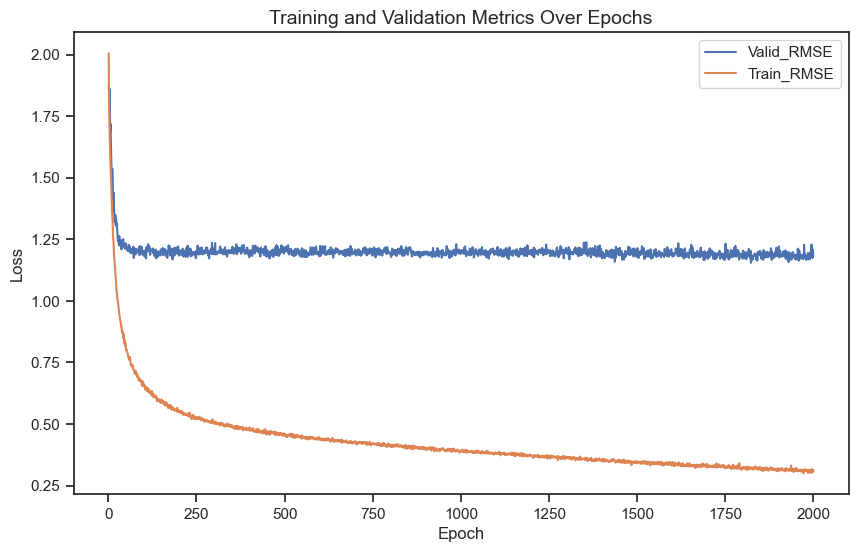

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')
# Load metrics

metrics = train_history

# Plot the training loss over epochs using seaborn
plt.figure(figsize=(10, 6))
# sns.lineplot(data=metrics, x='epoch', y='Train Loss', label='Train Loss')
# sns.lineplot(data=metrics, x='epoch', y='Val Loss', label='Val Loss')
sns.lineplot(data=metrics, x='epoch', y='Val MSE', label='Valid_RMSE')
sns.lineplot(data=metrics, x='epoch', y='Train MSE', label='Train_RMSE')
# sns.lineplot(data=metrics, x='Epoch', y='Valid_MAE', label='Valid_MAE')
# Add titles and labels
plt.title('Training and Validation Metrics Over Epochs', fontsize=14)
# Define the range of tick positions
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(False)
# Show the plot
plt.show()


In [ ]:
train_history.tail()

,epoch,Train Loss,Train MSE,Train MAE,Train RMSE,Train R2,Train Pearson,Train Median_AE,Train Explained_VARVal Loss,Val MSE,Val MAE,Val RMSE,Val R2,Val Pearson,Val Median_AE,Val Explained_VAR,Train Explained_VAR,Val Loss
1995,1996,0.316446,0.317172,0.368631,0.368631,0.861604,0.928230,0.234924,NaN,1.186353,0.730190,0.730190,0.495858,0.710324,0.491346,0.495964,0.861604,1.184328
1996,1997,0.310804,0.311459,0.364297,0.364297,0.864097,0.929570,0.229603,NaN,1.195141,0.730901,0.730901,0.492124,0.710543,0.485587,0.492295,0.864098,1.193281
1997,1998,0.312351,0.312465,0.364895,0.364895,0.863658,0.929343,0.231581,NaN,1.174222,0.733481,0.733481,0.501013,0.712172,0.488969,0.501183,0.863659,1.172062
1998,1999,0.304377,0.304810,0.362877,0.362877,0.866998,0.931129,0.229041,NaN,1.208051,0.744046,0.744046,0.486638,0.705293,0.500462,0.488176,0.867001,1.206207
1999,2000,0.312994,0.312532,0.363678,0.363678,0.863629,0.929318,0.229197,NaN,1.183363,0.734184,0.734184,0.497129,0.711472,0.495807,0.497719,0.863629,1.181514


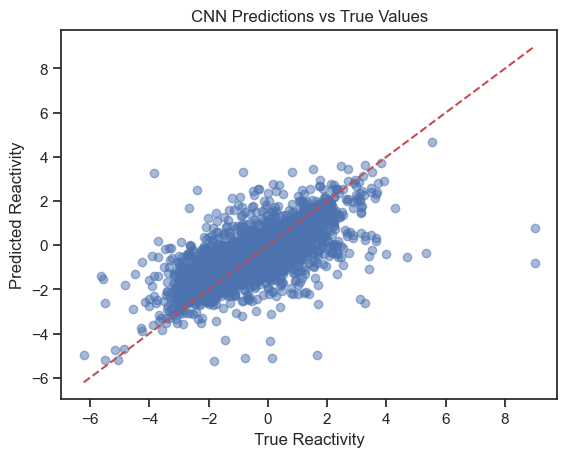

In [ ]:
# Plot the performance
import matplotlib.pyplot as plt

plt.scatter(test_labels, test_predictions, alpha=0.5)
plt.xlabel("True Reactivity")
plt.ylabel("Predicted Reactivity")
plt.title("CNN Predictions vs True Values")
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], 'r--')
plt.show()
